# Boosting

- [Import IKEA Furniture Data-Set](#Import-IKEA-Furniture-Data-Set)
    - [Clean and convert Data-Set](##Clean-and-convert-Data-Set)
- [Create Boosting ](#Create-Boosting)
    - [Create a First Version of Boosting](##Create-a-First-Version-of-Boosting)
    - [First Improvements of Boosting](##First-Improvements-of-Boosting)
    - [Final Version of Boosting](##Final-Version-of-Boosting)
    - [Further Investigations of Boosting Model](##Further-Investigations-of-Boosting-Model)
- [Conclusion](#Conclusion) 

In [44]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Import-IKEA-Furniture-Data-Set

In [45]:
#read the data and delete the index of entry
IKEA_df = pd.read_csv('IKEA_SA_Furniture_Web_Scrapings_sss.csv')
IKEA_df = IKEA_df.drop(IKEA_df.columns[0],axis =1)

#split description and size data in feature short description
IKEA_df['size']= IKEA_df['short_description'].str.rsplit(',', n=1).str[1]
IKEA_df['short_description']= IKEA_df['short_description'].str.rsplit(',', n=1).str[0]

#split numbers and unit
IKEA_df['unit'] = IKEA_df['size'].str.replace('\d+|-|x', ' ')
IKEA_df['size_nounit'] = IKEA_df['size'].str.replace('cm|mm', '')

IKEA_df['height'] = np.where(IKEA_df['unit'].str.contains('mm') , IKEA_df.size_nounit, IKEA_df.height)
IKEA_df['height'] = np.where(IKEA_df['unit'].str.contains('mm'), IKEA_df.height.astype(float)/10, IKEA_df.height)
IKEA_df['height'] = IKEA_df['height'].astype(float)

IKEA_df['depth'] = np.where(IKEA_df['unit'].str.contains('mm'), IKEA_df.depth.astype(float)/10, IKEA_df.depth)
IKEA_df['width'] = np.where(IKEA_df['unit'].str.contains('mm'), IKEA_df.width.astype(float)/10, IKEA_df.width)

#calculate median/mean of items of each furniture category 
dm =IKEA_df.groupby('category')['depth'].median().reset_index(name = 'depth_median')
dd = IKEA_df.groupby('category')['depth'].mean().reset_index(name = 'depth_mean')
hm = IKEA_df.groupby('category')['height'].mean().reset_index(name = 'height_mean')
wm= IKEA_df.groupby('category')['width'].median().reset_index(name = 'width_median')
wd =IKEA_df.groupby('category')['width'].mean().reset_index(name = 'width_mean')

IKEA_df = IKEA_df.join(dm.set_index('category'), on='category')
IKEA_df = IKEA_df.join(dd.set_index('category'), on='category')
IKEA_df = IKEA_df.join(hm.set_index('category'), on='category')
IKEA_df = IKEA_df.join(wm.set_index('category'), on='category')
IKEA_df = IKEA_df.join(wd.set_index('category'), on='category')

#add mean value if empty
IKEA_df['depth'] = np.where(IKEA_df['depth'].isnull(), IKEA_df.depth_mean, IKEA_df.depth)
IKEA_df['height'] = np.where(IKEA_df['height'].isnull(), IKEA_df.height_mean, IKEA_df.height)
IKEA_df['width'] = np.where(IKEA_df['width'].isnull(), IKEA_df.width_mean, IKEA_df.width)

#get column names
ikea_cols = IKEA_df.columns

#get unique labels of data
labels = IKEA_df['category'].unique()

## Clean and convert Data-Set

In [46]:
#for each column of type string convert to integer
enc = preprocessing.LabelEncoder()

for col in ikea_cols:
    if isinstance(IKEA_df[col][1], str):
        IKEA_df[col] = IKEA_df[col].astype('str')
        IKEA_df[col] = enc.fit_transform(IKEA_df[col])#drop category for trainingsdata
X = IKEA_df.drop('category', axis=1)
X = X.loc[:, :'width']

#use categroy as label
y = IKEA_df['category']

#save cast from label to int label in dict    
label_convert = {}
label_int = IKEA_df['category'].unique()
for i in range(len(labels)):
    label_convert[label_int[i]] = labels[i]     

# Create Boosting 

We are exploring the method of Boosting in order to classify the IKEA Furniture Data-Set.

In [47]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import time

## Create a First Version of Boosting

In [48]:
# split data into test and training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, random_state=1)

#define parameters for Booster (experimented with parameters, use of best combination for time/performance ratio)
lr = 0.005
est = 5000
d = 10

#create booster
booster = GradientBoostingRegressor(loss='ls', learning_rate=lr, n_estimators=est, max_depth=d, random_state=0)

#fit booster
boost_est = booster.fit(X_train, y_train)

# Make predictions
y_pred = boost_est.predict(X_test)

#search for lowest correct prediction of second class = 1
low_class1=100
for i in range(len(y_pred)):
    if y_test.iloc[i] == 1:
        tmp = np.amin(y_pred[i])
        if tmp < low_class1:
            low_class1 = tmp
#assign every prediction lower to the first class = 0
for i in range(len(y_pred)):
    if y_pred[i] < low_class1:
        y_pred[i] = 0
        
#cast predictions to integer values
y_pred = [round(value) for value in y_pred]

#calculate accuracy
a = accuracy_score(y_test, y_pred)
# Note : this acuracy is not weighted by sample size!!! 
print('Overall acuracy of all category: ' +str(a))


#check feature importance
feature_impo = pd.Series(data=boost_est.feature_importances_, index=list(X_train.columns))
feature_impo = feature_impo.sort_values(axis=0, ascending=False)
feature_impo

Overall acuracy of all category: 0.6426229508196721


depth                0.462170
height               0.237516
short_description    0.128388
link                 0.043111
width                0.030380
item_id              0.027623
designer             0.024593
price                0.023022
name                 0.015101
old_price            0.006470
other_colors         0.001351
sellable_online      0.000275
dtype: float64

Text(0.5, 1.0, 'Feature importance')

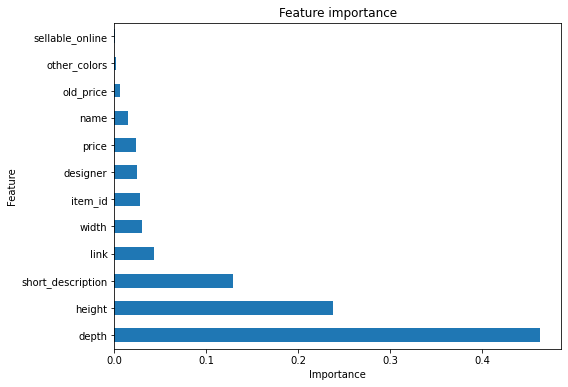

In [49]:
figip,axip = plt.subplots(1,1, figsize=(8,6))
feature_impo.plot(kind='barh', ax=axip)
axip.set_xlabel('Importance')
axip.set_ylabel('Feature')
axip.set_title('Feature importance')

Now lets check the confusion matrix to examine the acuracy for each category.

In [50]:
#confusion matrix
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(cm),len(cm)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(y_test.unique())):
    cm1[k,:] = cm[k,:]/cm_sum[k]

cm1 = cm1[0:len(y_test.unique()), 0:len(y_test.unique())]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = labels, columns=labels)

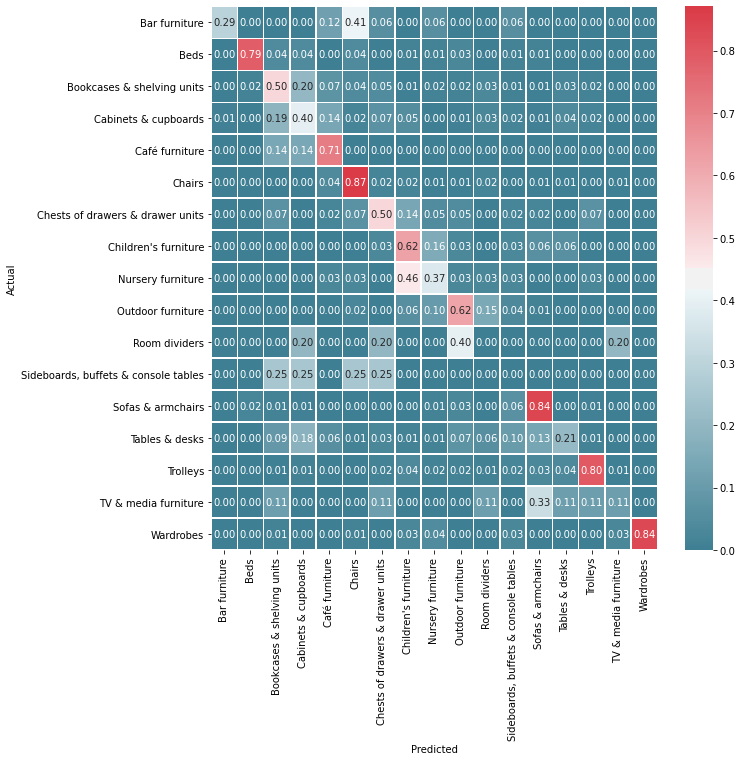

In [51]:
#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('boost_CM1.png', bbox_inches = 'tight')

If we look at the confusion matrix, we see that we have problems to classify bar furniture, cabinets & cupboards,
nursery furniture, room dividers, tables & desks and television & media furniture. We were also unable to classify room dividers and sideboards correctly at all. Due to these classification errors we need do improve our model. 

## First Improvements of Boosting

First improvement by a new selection of only important features may lead to a better performance. From the feature importance we can see wether a feature is needed or not. Due to their importance, only features with an value larger than 0.03 are selected for the improvment step. The selected features are **heigth, width, short_description, link and depth**.

In [52]:
#create list with features of good quality
improve = ['height','width','short_description','link' ,'depth', 'category']

#select important features
improveIKEA = IKEA_df[improve]

#drop category for trainingsdata
X = improveIKEA.drop('category', axis=1)

#use categroy as label
y = improveIKEA['category']

In [53]:
# split data into test and training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, random_state=1)

#create booster
booster = GradientBoostingRegressor(loss='ls', learning_rate=lr, n_estimators=est, max_depth=d, random_state=0)

#fit booster
boost_est = booster.fit(X_train, y_train)

# Make predictions
y_pred = boost_est.predict(X_test)

#search for lowest correct prediction of second class = 1
low_class1=100
for i in range(len(y_pred)):
    if y_test.iloc[i] == 1:
        tmp = np.amin(y_pred[i])
        if tmp < low_class1:
            low_class1 = tmp
#assign every prediction lower to the first class = 0
for i in range(len(y_pred)):
    if y_pred[i] < low_class1:
        y_pred[i] = 0
        
#cast predictions to integer values
y_pred = [round(value) for value in y_pred]

#calculate accuracy
a = accuracy_score(y_test, y_pred)
# Note : this acuracy is not weighted by sample size!!! 
print('Overall acuracy of all category: ' +str(a))

#check feature importance
feature_impo = pd.Series(data=boost_est.feature_importances_, index=list(X_train.columns))
feature_impo = feature_impo.sort_values(axis=0, ascending=False)
feature_impo

Overall acuracy of all category: 0.6893442622950819


depth                0.481403
height               0.248028
short_description    0.142323
link                 0.087769
width                0.040478
dtype: float64

The overall accuracy incresed due to our modifications from 64.3% to 68,9%.

Text(0.5, 1.0, 'Feature importance')

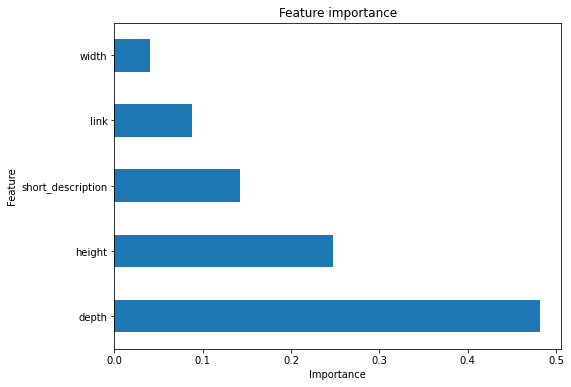

In [54]:
figip,axip = plt.subplots(1,1, figsize=(8,6))
feature_impo.plot(kind='barh', ax=axip)
axip.set_xlabel('Importance')
axip.set_ylabel('Feature')
axip.set_title('Feature importance')

We look again at the importance of the features to see if there are any major changes. From the data we can see that no value is below 0.03, which was the limit for selecting a feature in the first improvement step.

In [55]:
#confusion matrix
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(cm),len(cm)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(y_test.unique())):
    cm1[k,:] = cm[k,:]/cm_sum[k]

cm1 = cm1[0:len(y_test.unique()), 0:len(y_test.unique())]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = labels, columns=labels)

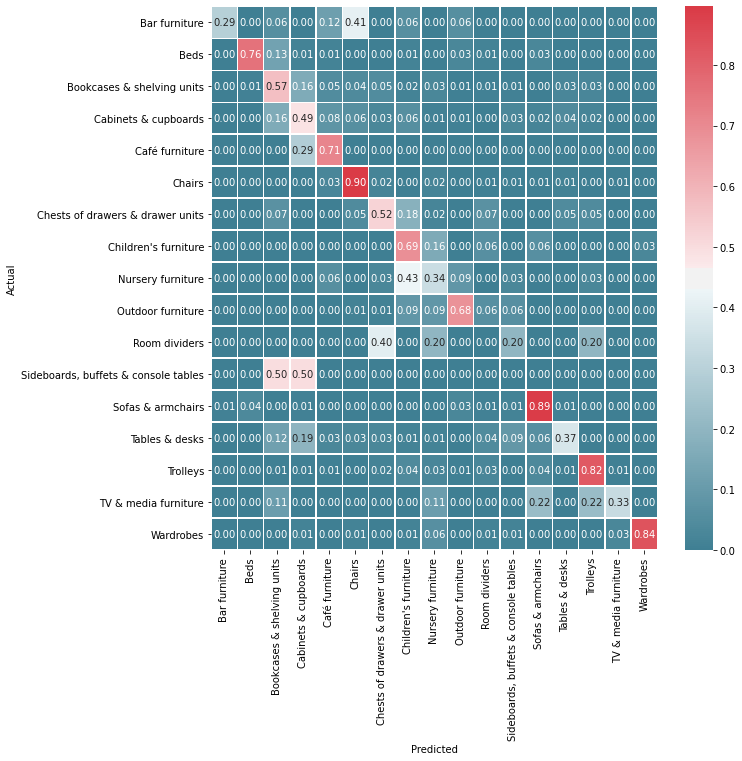

In [56]:
#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('boost_CM2.png', bbox_inches = 'tight')

If we now compare the current confusion matrix with the first one, we see that most of the classifications improved. Only the classes bar furniture, cafe furniture and wardrobes remained the same. Unfortunately the accuracy for beds and nursery furniture decreased each by 3%. Again we were not able to corrctly predict the classes room dividers and sideboards at all. Based on the analysis of the composition of our data, it should be noted that the classes room dividers and sideboards are underrepresented in the data. The unchanged problematic class for bar furniture is also underrepresented. Due to the remaining classification errors we need do improve our model once again. 

In [57]:
# determine training accuracy 
#y_pred_train = boost_est.predict(X_train)
#y_pred_train = [round(value) for value in y_pred_train]
#accuracy_train_1 = accuracy_score(y_train, y_pred_train)
#print("Model training accuracy:", accuracy_train_1)


# determine test accuracy
#accuracy_test_1 = accuracy_score(y_test, y_pred)
#print("Model test accuracy:", accuracy_test_1)

## Final Version of Boosting

In [58]:
#recall the sample size of each category
size_df = improveIKEA.groupby('category').size().reset_index(name='size')
size_df.replace({'category': label_convert})

,category,size
0,Bar furniture,47
1,Beds,208
2,Bookcases & shelving units,548
3,Cabinets & cupboards,292
4,Café furniture,26
5,Chairs,481
6,Chests of drawers & drawer units,125
7,Children's furniture,124
8,Nursery furniture,97
9,Outdoor furniture,216


In [59]:
#save number of unique labels
label_size = size_df['size'].tolist()
label_size

[47, 208, 548, 292, 26, 481, 125, 124, 97, 216, 13, 23, 428, 190, 612, 28, 236]

In [60]:
#copy data
improveIKEA2 = improveIKEA.copy() 


#serach for label in data and check relative frequency
for k in range(len(labels)):
    temp_df = improveIKEA.loc[improveIKEA['category'] == k]
    #print('original size' + str(temp_df.shape[0]))
    #print('label_size' +str(label_size[k]))
    tt = round(max(label_size)/label_size[k]) -1
    #print('to replicate' + str(tt))
    if tt > 0:
        temp_df1 = pd.concat([temp_df]*tt, ignore_index=True)
        #print('df_repl size' +str(temp_df1.shape[0]))
        improveIKEA2 = pd.concat([improveIKEA2, temp_df1] , ignore_index=True)
        #print(learn_df2.shape[0])

size_df2 = improveIKEA2.groupby('category').size().reset_index(name='size')
size_df2.replace({'category': label_convert})

,category,size
0,Bar furniture,611
1,Beds,624
2,Bookcases & shelving units,548
3,Cabinets & cupboards,584
4,Café furniture,624
5,Chairs,481
6,Chests of drawers & drawer units,625
7,Children's furniture,620
8,Nursery furniture,582
9,Outdoor furniture,648


In [1]:
#drop category for trainingsdata
X = improveIKEA2.drop('category', axis=1)

#use categroy as label
y = improveIKEA2['category']

# split data into test and training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, random_state=1)

#create booster
booster = GradientBoostingRegressor(loss='ls', learning_rate=0.001, n_estimators=5000, max_depth=15, random_state=0)

#fit booster
boost_est = booster.fit(X_train, y_train)

# Make predictions
y_pred = boost_est.predict(X_test)

#search for lowest correct prediction of second class = 1
low_class1=100
for i in range(len(y_pred)):
    if y_test.iloc[i] == 1:
        tmp = np.amin(y_pred[i])
        if tmp < low_class1:
            low_class1 = tmp
#assign every prediction lower to the first class = 0
for i in range(len(y_pred)):
    if y_pred[i] < low_class1:
        y_pred[i] = 0

#cast predictions to integer values
y_pred = [round(value) for value in y_pred]

#calculate accuracy
a = accuracy_score(y_test, y_pred)
# Note : this acuracy is not weighted by sample size!!! 
print('Overall acuracy of all category: ' +str(a))

#check feature importance
feature_impo = pd.Series(data=boost_est.feature_importances_, index=list(X_train.columns))
feature_impo = feature_impo.sort_values(axis=0, ascending=False)
feature_impo

NameError: name 'improveIKEA2' is not defined

Text(0.5, 1.0, 'Feature importance')

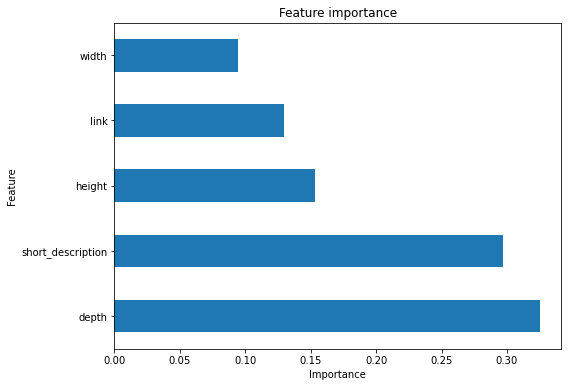

In [70]:
figip,axip = plt.subplots(1,1, figsize=(8,6))
feature_impo.plot(kind='barh', ax=axip)
axip.set_xlabel('Importance')
axip.set_ylabel('Feature')
axip.set_title('Feature importance')

In [71]:
#confusion matrix
cm =  confusion_matrix(y_test, y_pred)

# number of smaples actually belong to each category
cm_sum = cm.sum(axis = 1)

cm1 = np.zeros((len(cm),len(cm)))

# confusion matrix divided by  number of samples in test set belongs to each category 
for k in range(len(y_test.unique())):
    cm1[k,:] = cm[k,:]/cm_sum[k]

cm1 = cm1[0:len(y_test.unique()), 0:len(y_test.unique())]

# confusion_matrix normalized 
cm_df = pd.DataFrame(cm1,index = labels, columns=labels)

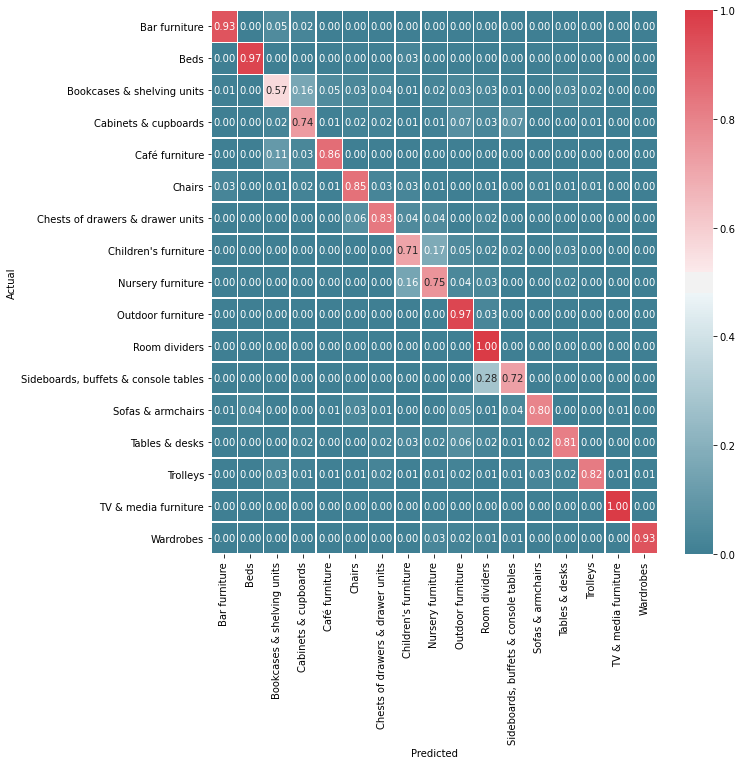

In [72]:
#plot confusion matrix 
fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm_df, annot=True, linewidths=.5,ax=ax,fmt='.2f',cmap = cmap)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.figure.savefig('boost_CM3.png', bbox_inches = 'tight')

The final version with the adjusted distribution of all classes improved the predictive power a lot. Now we can see a diagonal matrix that we need. Unfortunately the class for bookcases & shelvin units could not be improved and remains at a prediction level of 57%. Every others class performance increased except of the class for sofas & armchairs. This class lost 9% of its predictability. 

In [74]:
# determine training accuracy 
y_pred_train = boost_est.predict(X_train)
y_pred_train = [round(value) for value in y_pred_train]
accuracy_train_2 = accuracy_score(y_train, y_pred_train)
print("Model training accuracy:", accuracy_train_2)


# determine test accuracy
accuracy_test_2 = accuracy_score(y_test, y_pred)
print("Model test accuracy:", accuracy_test_2)

Model training accuracy: 0.8740959409594096
Model test accuracy: 0.8430197723187537


In [83]:
def train(X_train, X_test, y_train, y_test, boost):    

    booster = boost
    
    boost_est = booster.fit(X_train, y_train)
    
    
    # Examine the feature importances
    feature_importances = pd.Series(data=boost_est.feature_importances_, index=list(X_train.columns))
    sorted_feature_importances = feature_importances.sort_values(axis=0, ascending=False)
    #print(sorted_feature_importances)
    
    # Make predictions
    y_pred = boost_est.predict(X_test)
    
    # compute test mse
    mse = np.mean((y_test-y_pred)**2)
    #print("Test MSE = ", mse)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    return mse, accuracy, sorted_feature_importances, boost_est, y_pred

## Further Investigations of Boosting Model

In [86]:
estimator = [5000, 7500, 10000]
learning_rate = [0.01, 0.005, 0.001]
depth = [5, 15] 

In [87]:
#result = pd.Dataframe(columns=["learning rate", "estimators", "depth", "time", "mse", "accuracy", "importance"])
result = []

#run through all parameters to find best solution
for lr in learning_rate:
    for est in estimator:
        for d in depth:
            #print("Run lr: %4.3f, estimator: %d, depth: %d" % (lr, est, d))
            start_time = time.time()
            booster = GradientBoostingRegressor(loss='ls', learning_rate=lr, n_estimators=est, max_depth=d, random_state=0)
            mse, accuracy, sorted_feature_importances, boost_est, y_pred = train(X_train, X_test, y_train, y_test, booster) 
            end_time = time.time() - start_time
            #save results
            result.append(
                {
                    'learning rate': lr,
                    'estimators': est ,
                    'depth': d,
                    'time': end_time,
                    'mse': mse,
                    'accuracy': accuracy,
                    'importance': sorted_feature_importances
                    }
                )
            print('===========Process for Param estimator %d, lr %4.3f, depth %i, ===========' % (est, lr, d))
            print('time consumption: '+ str(end_time))
            print('Overall acuracy: ' +str(accuracy))
            print('Overall mse: ' +str(mse)+ "\n")

===========Process for Param estimator 5000, lr 0.010, depth 5, ===========
time consumption: 76.41200137138367
Overall acuracy: 0.7198921509886159
Overall mse: 2.7397441227431245

===========Process for Param estimator 5000, lr 0.010, depth 15, ===========
time consumption: 196.65350770950317
Overall acuracy: 0.82893948472139
Overall mse: 3.187755666739353

===========Process for Param estimator 7500, lr 0.010, depth 5, ===========
time consumption: 115.72263050079346
Overall acuracy: 0.7672258837627322
Overall mse: 2.754813964449372

===========Process for Param estimator 7500, lr 0.010, depth 15, ===========
time consumption: 302.01894426345825
Overall acuracy: 0.82893948472139
Overall mse: 3.1877578811581246

===========Process for Param estimator 10000, lr 0.010, depth 5, ===========
time consumption: 151.71877479553223
Overall acuracy: 0.7908927501497903
Overall mse: 2.7904470783423942

===========Process for Param estimator 10000, lr 0.010, depth 15, ===========
time consumption

In [98]:
#result to pandas DataFrame
res = pd.DataFrame(result)

#search for the accuracy better than 0.8
best_list = []
best = 1000
ident = 0
for i in range(len(res)):
    tmp = res['time'][i]/res['accuracy'][i]
    if best > tmp and res['accuracy'][i] > 0.8:
        best = tmp
        ident = i
        best_list.append([i])

est =res['estimators'][ident]
lr = res['learning rate'][ident]
d = res['depth'][ident]
accuracy = res['accuracy'][ident]
time = res['time'][ident]
    
print("depth: %d, lr: %4.3f, depth: %i, accuracy: %4.3f, time consumption: %i" % (est, lr, d, accuracy, time))

depth: 5000, lr: 0.001, depth: 15, accuracy: 0.823, time consumption: 145


# Conclusion